In [1]:
import geopandas as gpd
from shapely import wkt
import pandas as pd
import base64
from shapely import wkb
import os
import leafmap.leafmap as leafmap
#from rasterstats import zonal_stats
import rasterio
from shapely.geometry import Point
#from rasterstats import point_query
#import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import requests
from collections import Counter
from shapely.geometry import MultiPolygon, Polygon
import time
#import phik
from sklearn.preprocessing import PowerTransformer
from sklearn import set_config

import osmnx as ox
import geopandas as gpd
pd.options.display.max_columns = None
set_config(transform_output='pandas')
base = '/home/sinatrafrancoise'
path_data = f"{base}/data"


In [4]:
nyc_poly = ox.geocode_to_gdf("New York City, New York, USA").geometry.iloc[0]
# Download building data with polygon geometries
print("Downloading building data from OSM...")
gdf_buildings = ox.features_from_polygon(
    nyc_poly,
    tags={"building": True}
)
# Filter to only keep polygons (drop points or lines if any)
gdf_buildings = gdf_buildings[gdf_buildings.geometry.type.isin(["Polygon", "MultiPolygon"])]

# Reset index for cleaner output
gdf_buildings.reset_index(inplace=True)
# Show basic info
print(f"Downloaded {len(gdf_buildings)} buildings in NYC.")
# Optional: Save to GeoJSON
#gdf_buildings.to_file("nyc_buildings.geojson", driver="GeoJSON")
df = gdf_buildings
df["geometry"] = gdf_buildings.geometry.to_wkt()
df = pd.DataFrame(df)
df.to_parquet(f"{path_data}/nyc_buildings.parquet", index=False)
# Optional: Save to Shapefile
# gdf_buildings.to_file("nyc_buildings.shp")
# Display first few records
#print(gdf_buildings[['osm_id', 'building', 'name', 'geometry']].head())

Downloaded 1083095 buildings in NYC.


ArrowInvalid: ("Could not convert '1' with type str: tried to convert to int64", 'Conversion failed for column id with type object')

In [5]:
df = df.drop(columns=["ref", "REF"], errors="ignore")
df = df.drop(columns=["ref:lpc"], errors="ignore")
df.to_csv(f"{path_data}/nyc_buildings.csv", index=False)

In [2]:
df = pd.read_csv(f"{path_data}/nyc_buildings.csv")

In [ ]:
df

,element,id,geometry,building,ele,gnis:feature_id,name,addr:housenumber,addr:postcode,addr:street,amenity,denomination,nycdoitt:bin,religion,addr:state,source,height,website,historic,wikidata,addr:city,building:colour,building:levels,building:material,roof:material,roof:shape,tourism,fixme,alt_name,addr:country,wikipedia,brewery,opening_hours,outdoor_seating,smoking,toilets:wheelchair,wheelchair,club,leisure,short_name,sport,cemetery,bus,public_transport,addr:housename,phone,designation,isced:level,brand,brand:wikidata,operator,cuisine,description,takeaway,toilets,addr:unit,shop,email,fax,memorial,building:use,indoor_seating,contact:website,service_times,service:bicycle:diy,service:bicycle:rental,service:bicycle:repair,service:bicycle:retail,clothes,drive_through,official_name,access,operator:type,parking,generator:method,generator:output:electricity,generator:source,generator:type,layer,power,check_date,opening_hours:url,payment:cash,payment:credit_cards,payment:debit_cards,reservation,atm,opening_hours:signed,construction,entrance,barrier,kerb,tactile_paving,consulate,country,diplomatic,emergency_telephone_code,name:en,name:pl,office,official_name:pl,target,contact:facebook,diet:halal,not:brand:wikidata,delivery,grades,architect,architect:wikidata,start_date,building:architecture,year_of_construction,heritage,heritage:operator,max_level,min_level,nrhp:criteria,nrhp:inscription_date,ref:nrhp,ref:isil,roof:levels,branch,internet_access,internet_access:fee,healthcare,operator:wikidata,fee,supervised,surface,internet_access:ssid,building:flats,wikimedia_commons,historic:civilization,aerialway,artist_name,artwork_type,building:part,image,importance,inscription,landmark,material,monument,name:af,name:ar,name:azb,name:ba,name:be,name:cs,name:da,name:de,name:el,name:es,name:et,name:eu,name:fi,name:fr,name:he,name:hi,name:hu,name:it,name:ja,name:kaa,name:ko,name:lt,name:nl,name:pt,name:ro,name:ru,name:sk,name:sl,name:sr,name:sv,name:tt,name:uk,name:ur,name:zh,official_name:en,roof:colour,seamark:landmark:category,survey:date,air_conditioning,fast_food,name:tr,government,information,construction_date,military,source_ref,bunker_type,level,bridge,landuse,residential,ferry,war_memorial,website:alternate,old_name,name:hr,name:zh-Latn-pinyin,short_name:de,short_name:es,short_name:fr,short_name:pl,ship:type,exhibit,outdoor,rooms,architect:wikipedia,heritage:website,lpc:inscription_date,owner,min_height,female,male,bar,disused:tourism,nysgissam:nysaddresspointid,nysgissam:review,plant:method,plant:output:electricity,plant:source,telecom,operator:short,operator:website,operator:wikipedia,toilets:fee,man_made,check_date:opening_hours,fee:conditional,roof:height,roof:orientation,postal_code,charge,indoor,last_checked,length,lifeguard,location,note,nudism,swimming,swimming_lanes,swimming_pool,attraction,apartments,roof:direction,team,team_2,townhall:type,toilets:access,toilets:unisex,computer:repair,mobile_phone:repair,payment:american_express,payment:diners_club,payment:discover_card,payment:jcb,payment:mastercard,payment:visa,stroller,addr:flats,toilets:disposal,diocese,brand:short,contact:instagram,contact:pinterest,contact:twitter,fitness_centre,social_facility,social_facility:for,disused,name:zh-Hans,source:geometry,screen,contact:phone,museum,ref:whc,protection_title,nrhp:nhl,building:levels:underground,contact:youtube,emergency,building:min_level,collection_times,dog,payment:carte_blanche,payment:union_pay,payment:contactless,unisex,brand:wikipedia,opening_hours:covid19,payment:cheque,aeroway,opening_hours:drive_through,content,type,network,denomination:en,abandoned,house,drink:coffee,seasonal,toilets:female,toilets:male,check_date:diet:gluten_free,diet:gluten_free,diet:kosher,organic,old_nycdoitt:bin,drink:beer,drink:wine,happy_hours,nohousenumber,NY_mta:propcode,exit,railway,disused:shop,beauty,opening_hours:kitchen,service:copy,service:fax,service:notary,pets,opening_date,craft,reservation:covid19,disused:website,disused:amenity,highch

In [4]:
null_counts = {}

for col_name in df.columns:
    if pd.api.types.is_numeric_dtype(df[col_name]):
        null_count = df[col_name].isnull().sum() + np.isnan(df[col_name].dropna()).sum()
    else:
        null_count = df[col_name].isnull().sum()

    null_counts[col_name] = null_count

# Total nulls across the entire DataFrame
total_count = sum(null_counts.values())

# Print results
print(null_counts)
print(f"Total count of null values: {total_count}")
print(f"Total count of rows: {len(df)}")

{'element': np.int64(0), 'id': np.int64(0), 'geometry': np.int64(0), 'building': np.int64(0), 'ele': np.int64(1080794), 'gnis:feature_id': np.int64(1080690), 'name': np.int64(1071854), 'addr:housenumber': np.int64(294392), 'addr:postcode': np.int64(296269), 'addr:street': np.int64(293906), 'amenity': np.int64(1078562), 'denomination': np.int64(1082045), 'nycdoitt:bin': np.int64(14135), 'religion': np.int64(1081399), 'addr:state': np.int64(1073079), 'source': np.int64(1082379), 'height': np.int64(16433), 'website': np.int64(1080069), 'historic': np.int64(1082192), 'wikidata': np.int64(1081126), 'addr:city': np.int64(1071419), 'building:colour': np.int64(1080770), 'building:levels': np.int64(1064317), 'building:material': np.int64(1081322), 'roof:material': np.int64(1080918), 'roof:shape': np.int64(1078864), 'tourism': np.int64(1082480), 'fixme': np.int64(1082953), 'alt_name': np.int64(1082505), 'addr:country': np.int64(1082316), 'wikipedia': np.int64(1082027), 'brewery': np.int64(108309

In [46]:
1083095-1083093

2

In [3]:
columns_to_keep = [
    'element',
    'id',
    'geometry',
    'building',
    'height',
    'building:levels',
    'building:use',
    'building:material',
    'roof:material',
    'roof:shape',
    'roof:height',
    'addr:housenumber',
    'addr:street',
    'addr:postcode',
    'addr:city',
    'addr:state',
    'addr:country',
    'addr:district',
    'addr:suburb',
    'addr:block',
    'amenity',
    'shop',
    'office',
    'leisure',
    'healthcare',
    'tourism',
    'historic',
    'memorial',
    'religion',
    'denomination',
    'man_made',
    'industrial',
    'landuse',
    'lit',
    'access',
    'wheelchair',
    'entrance',
    'nycdoitt:bin',
    'source',
    'start_date',
    'year_of_construction',
    'building:start_date',
    'historic:civilization',
    'opening_hours',
    'usage',
    'residential',
    'building:flats',
    'surface',
    'material'
]


In [6]:
df_filtered = df[[col for col in columns_to_keep if col in df.columns]]
df_filtered.to_csv(f"{path_data}/nyc_filtered_buildings.csv", index=False)


In [ ]:
df_parts = np.array_split(df, 5)

for i, part in enumerate(df_parts):
    part.to_csv(f"{path_data}/nyc_part_{i+1}.csv", index=False)

In [35]:
df_n1 = pd.read_csv(f"{path_data}/nyc_part_1.csv")
df_n1

,element,id,geometry,building,ele,gnis:feature_id,name,addr:housenumber,addr:postcode,addr:street,amenity,denomination,nycdoitt:bin,religion,addr:state,source,height,website,historic,wikidata,addr:city,building:colour,building:levels,building:material,roof:material,roof:shape,tourism,fixme,alt_name,addr:country,wikipedia,brewery,opening_hours,outdoor_seating,smoking,toilets:wheelchair,wheelchair,club,leisure,short_name,sport,cemetery,bus,public_transport,addr:housename,phone,designation,isced:level,brand,brand:wikidata,operator,cuisine,description,takeaway,toilets,addr:unit,shop,email,fax,memorial,building:use,indoor_seating,contact:website,service_times,service:bicycle:diy,service:bicycle:rental,service:bicycle:repair,service:bicycle:retail,clothes,drive_through,official_name,access,operator:type,parking,generator:method,generator:output:electricity,generator:source,generator:type,layer,power,check_date,opening_hours:url,payment:cash,payment:credit_cards,payment:debit_cards,reservation,atm,opening_hours:signed,construction,entrance,barrier,kerb,tactile_paving,consulate,country,diplomatic,emergency_telephone_code,name:en,name:pl,office,official_name:pl,target,contact:facebook,diet:halal,not:brand:wikidata,delivery,grades,architect,architect:wikidata,start_date,building:architecture,year_of_construction,heritage,heritage:operator,max_level,min_level,nrhp:criteria,nrhp:inscription_date,ref:nrhp,ref:isil,roof:levels,branch,internet_access,internet_access:fee,healthcare,operator:wikidata,fee,supervised,surface,internet_access:ssid,building:flats,wikimedia_commons,historic:civilization,aerialway,artist_name,artwork_type,building:part,image,importance,inscription,landmark,material,monument,name:af,name:ar,name:azb,name:ba,name:be,name:cs,name:da,name:de,name:el,name:es,name:et,name:eu,name:fi,name:fr,name:he,name:hi,name:hu,name:it,name:ja,name:kaa,name:ko,name:lt,name:nl,name:pt,name:ro,name:ru,name:sk,name:sl,name:sr,name:sv,name:tt,name:uk,name:ur,name:zh,official_name:en,roof:colour,seamark:landmark:category,survey:date,air_conditioning,fast_food,name:tr,government,information,construction_date,military,source_ref,bunker_type,level,bridge,landuse,residential,ferry,war_memorial,website:alternate,old_name,name:hr,name:zh-Latn-pinyin,short_name:de,short_name:es,short_name:fr,short_name:pl,ship:type,exhibit,outdoor,rooms,architect:wikipedia,heritage:website,lpc:inscription_date,owner,min_height,female,male,bar,disused:tourism,nysgissam:nysaddresspointid,nysgissam:review,plant:method,plant:output:electricity,plant:source,telecom,operator:short,operator:website,operator:wikipedia,toilets:fee,man_made,check_date:opening_hours,fee:conditional,roof:height,roof:orientation,postal_code,charge,indoor,last_checked,length,lifeguard,location,note,nudism,swimming,swimming_lanes,swimming_pool,attraction,apartments,roof:direction,team,team_2,townhall:type,toilets:access,toilets:unisex,computer:repair,mobile_phone:repair,payment:american_express,payment:diners_club,payment:discover_card,payment:jcb,payment:mastercard,payment:visa,stroller,addr:flats,toilets:disposal,diocese,brand:short,contact:instagram,contact:pinterest,contact:twitter,fitness_centre,social_facility,social_facility:for,disused,name:zh-Hans,source:geometry,screen,contact:phone,museum,ref:whc,protection_title,nrhp:nhl,building:levels:underground,contact:youtube,emergency,building:min_level,collection_times,dog,payment:carte_blanche,payment:union_pay,payment:contactless,unisex,brand:wikipedia,opening_hours:covid19,payment:cheque,aeroway,opening_hours:drive_through,content,type,network,denomination:en,abandoned,house,drink:coffee,seasonal,toilets:female,toilets:male,check_date:diet:gluten_free,diet:gluten_free,diet:kosher,organic,old_nycdoitt:bin,drink:beer,drink:wine,happy_hours,nohousenumber,NY_mta:propcode,exit,railway,disused:shop,beauty,opening_hours:kitchen,service:copy,service:fax,service:notary,pets,opening_date,craft,reservation:covid19,disused:website,disused:amenity,highch

In [34]:
#df = pd.read_csv('crimesUsa.csv')

In [ ]:
satellite = f"{path_data}/BlackMarble_2016_C1_geo.tif"

m.add_raster(satellite, colormap="viridis", layer_name="Black Marble")

In [3]:
base = '/home/evharthman'
path_data = f"{base}/data"

In [7]:
m = leafmap.Map(center=(40, -100), zoom=4)

In [9]:
m = leafmap.Map(center=(40, -100), zoom=4)
small_sat = f"{path_data}/BlackMarble_2016_3km_geo.tif"
m.add_raster(small_sat,  layer_name="Black Marble Small")
m.add_layer_control()
m

Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

In [16]:
df.head()

,ID,Date,PD_CD,Description,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,age,...,FBI Code,Year,Updated On,Location,City,crime_code,year,Month,day,datetime
0,109557691,2014-04-14T00:00:00.000000,848,OTHER STATE LAWS (NON PENAL LAW),LOC00000UM,M,M,22,0,25-44,...,NaN,0,NaN,NaN,NYC,364.0,2014,April,14,2014-04-14T00:00:00.000000
1,109557692,2014-04-14T00:00:00.000000,849,OTHER STATE LAWS,LOC000000V,V,Q,110,0,25-44,...,NaN,0,NaN,NaN,NYC,677.0,2014,April,14,2014-04-14T00:00:00.000000
2,109557693,2014-04-13T00:00:00.000000,922,VEHICLE AND TRAFFIC LAWS,VTL0511001,M,B,40,0,25-44,...,NaN,0,NaN,NaN,NYC,348.0,2014,April,13,2014-04-13T00:00:00.000000
3,109557694,2014-04-14T00:00:00.000000,922,VEHICLE AND TRAFFIC LAWS,VTL0511001,M,B,43,0,25-44,...,NaN,0,NaN,NaN,NYC,348.0,2014,April,14,2014-04-14T00:00:00.000000
4,109557695,2014-04-14T00:00:00.000000,922,VEHICLE AND TRAFFIC LAWS,VTL0511001,M,Q,110,0,25-44,...,NaN,0,NaN,NaN,NYC,348.0,2014,April,14,2014-04-14T00:00:00.000000


In [18]:
df.columns

Index(['ID', 'Date', 'PD_CD', 'Description', 'LAW_CODE', 'LAW_CAT_CD',
       'ARREST_BORO', 'ARREST_PRECINCT', 'JURISDICTION_CODE', 'age', 'sex',
       'race', 'X Coordinate', 'Y Coordinate', 'Latitude', 'Longitude',
       'Lon_Lat', 'geom', 'District', 'intersects', 'Block', 'Primary Type',
       'Arrest', 'Domestic', 'Beat', 'Community Area', 'FBI Code', 'Year',
       'Updated On', 'Location', 'City', 'crime_code', 'year', 'Month', 'day',
       'datetime'],
      dtype='object')

In [19]:
print(df['Lon_Lat'].head(10))


0     POINT (-73.96587826899997 40.78245186000004)
1     POINT (-73.86537333399998 40.74960053300003)
2     POINT (-73.90907618199996 40.81324161600002)
3     POINT (-73.87550694899994 40.82924217100003)
4     POINT (-73.86525182699995 40.74722069000006)
5     POINT (-73.89388512599999 40.66149861600008)
6    POINT (-73.91770925599997 40.834516921000045)
7    POINT (-73.96818808299997 40.762234771000074)
8     POINT (-73.94475961199998 40.82404000400004)
9     POINT (-74.00441632199994 40.65431497600008)
Name: Lon_Lat, dtype: object


          ID                        Date  PD_CD  \
0  109557691  2014-04-14T00:00:00.000000    848   
1  109557692  2014-04-14T00:00:00.000000    849   
2  109557693  2014-04-13T00:00:00.000000    922   
3  109557694  2014-04-14T00:00:00.000000    922   
4  109557695  2014-04-14T00:00:00.000000    922   

                        Description    LAW_CODE LAW_CAT_CD ARREST_BORO  \
0  OTHER STATE LAWS (NON PENAL LAW)  LOC00000UM          M           M   
1                  OTHER STATE LAWS  LOC000000V          V           Q   
2          VEHICLE AND TRAFFIC LAWS  VTL0511001          M           B   
3          VEHICLE AND TRAFFIC LAWS  VTL0511001          M           B   
4          VEHICLE AND TRAFFIC LAWS  VTL0511001          M           Q   

   ARREST_PRECINCT  JURISDICTION_CODE    age  ... Year Updated On  Location  \
0               22                  0  25-44  ...    0        NaN       NaN   
1              110                  0  25-44  ...    0        NaN       NaN   
2          

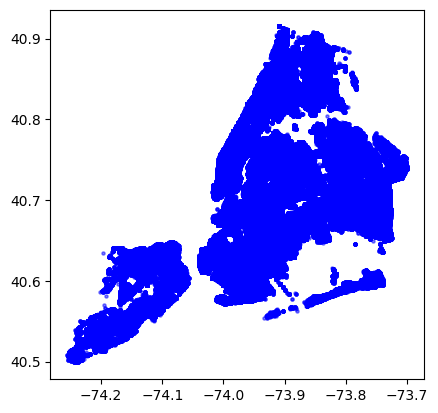

In [21]:
def safe_wkt_loads(x):
    if isinstance(x, str):
        return wkt.loads(x)
    else:
        return None
df['geometry'] = df['Lon_Lat'].apply(safe_wkt_loads)

gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf = gdf.dropna(subset=['geometry'])
gdf.set_crs(epsg=4326, inplace=True)

gdf.plot(markersize=5, color='blue', alpha=0.5)
print(gdf.head())

In [23]:
gdf.to_file("Geodata.geojson", driver="GeoJSON")
